## Jack's Car Rental

Jack manages two locations for a nationwide car rental company. Each day, some number of customers arrive at each location to rent cars.  
  
If Jack has a car available, he rents it out and is `RENTAL_CREDITed $10`
If he is out of cars at that location, then the business is lost  
  
Cars become availabel for renting the day after they are returned. To help ensure that cars are availabel, sometimes Jack need to move them between the two locations overnight, at `a cost of $2 per car moved`.  
  
Number of `cars requested` and `returned` at each location are `Poisson random variables`, meaning that the probability that the number is $n$ is $\frac{\lambda^n}{n!}e^{-\lambda}$, where $\lambda$ is the expected number.  
  
Suppose $\lambda$ is `3` and `4` for rental request at the first and second locations and `3` and `2` for returns.  
  
We assume that   
    - There can be no more than `20 cars` at each location  
    - A maximum of `5 cars` can be moved from one location to the other in one night  
  
We take  
    - DISCOUNT rate $\gamma = 0.9$  
    - time steps are days  
    - `state` is the number of cars at each location at the end of the day  
    - `actions` are the net numbers of cars moved between the two locations overnigth


### Matrix version

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats
from typing import List

MAX_CAR_LIMIT = 20  # maximum # of cars in each location
MAX_MOVE_LIMIT = 5  # maximum # of cars to move durint night
EXP_REQ_1 = 3       # expectation of rental requests in 1st location
EXP_REQ_2 = 4       # expectation of rental requests in 2nd location
EXP_RET_1 = 3       # expectation of returned cars in 1st location
EXP_RET_2 = 2       # expectation of returned cars in 2nd location

stateValues = np.zeros((MAX_CAR_LIMIT + 1, MAX_CAR_LIMIT + 1))  # state value
policy = np.zeros(stateValues.shape, dtype = int)               # store action taken of each state

DISCOUNT = 0.9

RENTAL_CREDIT = 10      # RENTAL_CREDIT earned by a car
MOVE_CAR_COST = 2       # cost of moving a car

actions = np.arange(-MAX_MOVE_LIMIT, MAX_MOVE_LIMIT + 1)

POISSION_UPPER_BOUND = 12   # If n is greater than 12, then the probability of getting n is truncated to 0.

reqProb1 = stats.poisson.pmf(np.arange(POISSION_UPPER_BOUND), EXP_REQ_1)
reqProb2 = stats.poisson.pmf(np.arange(POISSION_UPPER_BOUND), EXP_REQ_2)
reqProb2, reqProb1 = np.meshgrid(reqProb2, reqProb1)
RENTAL_PROB = np.multiply(reqProb1, reqProb2)

retProb1 = stats.poisson.pmf(np.arange(POISSION_UPPER_BOUND), EXP_RET_1)
retProb2 = stats.poisson.pmf(np.arange(POISSION_UPPER_BOUND), EXP_RET_2)
retProb2, retProb1 = np.meshgrid(retProb2, retProb1)
RETURN_PROB = np.multiply(retProb1, retProb2)


num1 = np.arange(POISSION_UPPER_BOUND)
num2 = np.arange(POISSION_UPPER_BOUND)
num2, num1 = np.meshgrid(num2, num1)


def get_return(state, action: int, stateValues: np.array, constantReturnedCars: bool = True):
    returns = 0.0
    returns -= MOVE_CAR_COST * abs(action)

    # avalable cars
    numOfCarsFirstLoc = int(min(state[0] - action, MAX_CAR_LIMIT))
    numOfCarsSecondLoc = int(min(state[1] + action, MAX_CAR_LIMIT))

    numReq = np.vstack([num2.ravel(), num1.ravel()]).T
    numReq.resize((POISSION_UPPER_BOUND, POISSION_UPPER_BOUND, 2))
    numReq[numReq[:,:,0] > numOfCarsFirstLoc, 0] = numOfCarsFirstLoc
    numReq[numReq[:,:,1] > numOfCarsSecondLoc, 1] = numOfCarsSecondLoc
    
    reward = np.sum(numReq, axis = 2) * RENTAL_CREDIT

    num = [numOfCarsFirstLoc, numOfCarsSecondLoc] - numReq

    if constantReturnedCars:
        # update state
        num += [EXP_RET_1, EXP_RET_2]
        num[num > MAX_CAR_LIMIT] = MAX_CAR_LIMIT

        values = stateValues[num[:, :, 0], num[:, :, 1]]

        returns += np.sum(RENTAL_PROB * (reward + DISCOUNT * values))
    
    else:
        numRet = np.vstack([num1.ravel(), num2.ravel()]).T
        numRet.resize((POISSION_UPPER_BOUND, POISSION_UPPER_BOUND, 2))

        num += numRet
        num[num[:,:,0] > MAX_CAR_LIMIT, 0] = MAX_CAR_LIMIT
        num[num[:,:,1] > MAX_CAR_LIMIT, 1] = MAX_CAR_LIMIT

        values = stateValues[num[:, :, 0], num[:, :, 1]]
        returns += np.sum(RENTAL_PROB * RETURN_PROB * (reward + DISCOUNT * values))
    
    return returns


def policy_iteration():
    iterations = 0
    _, axes = plt.subplots(2, 3, figsize = (40, 20))
    plt.subplots_adjust(wspace=0.1, hspace=0.2)
    axes = axes.flatten()

    while True:
        fig = sns.heatmap(np.flipud(policy), cmap = 'YlGnBu', ax = axes[iterations])
        fig.set_ylabel('# cars at 1st location', fontsize = 30)
        fig.set_yticks(list(reversed(range(MAX_CAR_LIMIT + 1))))
        fig.set_xlabel('# cars at 2nd location', fontsize = 30)
        fig.set_title('policy {}'.format(iterations), fontsize = 30)

        while True:
            old_value = stateValues.copy()
            for i in range(MAX_CAR_LIMIT + 1):
                for j in range(MAX_CAR_LIMIT + 1):
                    update_stateValue = get_return([i, j], policy[i, j], stateValues)
                    stateValues[i, j] = update_stateValue
            
            max_value_change = abs(old_value - stateValues).max()
            print('max value change {}'.format(max_value_change))
            if max_value_change < 1e-4:
                break
        

        # policy improvement
        policy_stable = True
        for i in range(MAX_CAR_LIMIT + 1):
            for j in range(MAX_CAR_LIMIT + 1):
                old_action = policy[i, j]
                action_returns = []
                for action in actions:
                    if (0 <= action <= i) or (-j <= action <= 0):
                        action_returns.append(get_return([i, j], action, stateValues))
                    else:
                        action_returns.append(-np.inf)
                
                update_action = actions[np.argmax(action_returns)]
                policy[i, j] = update_action
                if policy_stable and old_action != update_action:
                    policy_stable = False
        
        print('policy state: {}'.format(policy_stable))

        if policy_stable:
            fig = sns.heatmap(np.flipud(stateValues), cmap = 'YlGnBu', ax = axes[-1])
            fig.set_ylabel('# cars at 1st location', fontsize = 30)
            fig.set_yticks(list(reversed(range(MAX_CAR_LIMIT + 1))))
            fig.set_xlabel('# cars at 2nd location', fontsize = 30)
            fig.set_title('optimal value', fontsize = 30)
            break
            
        iterations +=1
    
    # plt.savefig('./policy_iteration.png')
    plt.show()
    plt.close()

    def addSubplot(ax, data, label):
        AxisZ = []
        AxisXPrint = []
        AxisYPrint = []
        for i in range(MAX_CAR_LIMIT + 1):
            for j in range(MAX_CAR_LIMIT + 1):
                AxisXPrint.append(i)
                AxisYPrint.append(j)
                AxisZ.append(data[i, j])

        ax.scatter(AxisXPrint, AxisYPrint, AxisZ)
        ax.set_xlabel(label[0])
        ax.set_ylabel(label[1])
        ax.set_zlabel(label[2])

    def gen3d(policy, stateValues):
        fig = plt.figure(figsize=(14, 6))  # 设置整个画布的大小
        ax1 = fig.add_subplot(121, projection='3d')  # 第一个子图
        ax2 = fig.add_subplot(122, projection='3d')  # 第二个子图

        addSubplot(ax1, policy, ['# of cars in 1st location', '# of cars in 2nd location', '# of cars to move during night'])
        addSubplot(ax2, stateValues, ['# of cars in 1st location', '# of cars in 2nd location', 'expected returns'])

        # plt.savefig('./exp-3d.png')  
        plt.show()  
        
    
    gen3d(policy, stateValues)


max value change 198.1079485883324
max value change 136.32490191125737
max value change 92.53923698451817
max value change 68.0023035358748
max value change 52.04300521979985
max value change 39.17030871580795
max value change 29.94176676694272
max value change 26.266800613926875
max value change 22.924590750377718
max value change 19.934306268581167
max value change 17.286495823685016
max value change 14.95847138351968
max value change 12.921987878176651
max value change 11.147262830396244
max value change 9.605124198931492
max value change 8.268133196882445
max value change 7.111117365019993
max value change 6.111358352453067
max value change 5.248580715600781
max value change 4.504831459025695
max value change 3.8643050112786455
max value change 3.313146238506704
max value change 2.8392503272417002
max value change 2.4320699590262507
max value change 2.0824351667483256
max value change 1.7823883005074777
max value change 1.525034814870196
max value change 1.3044096154714566
max valu

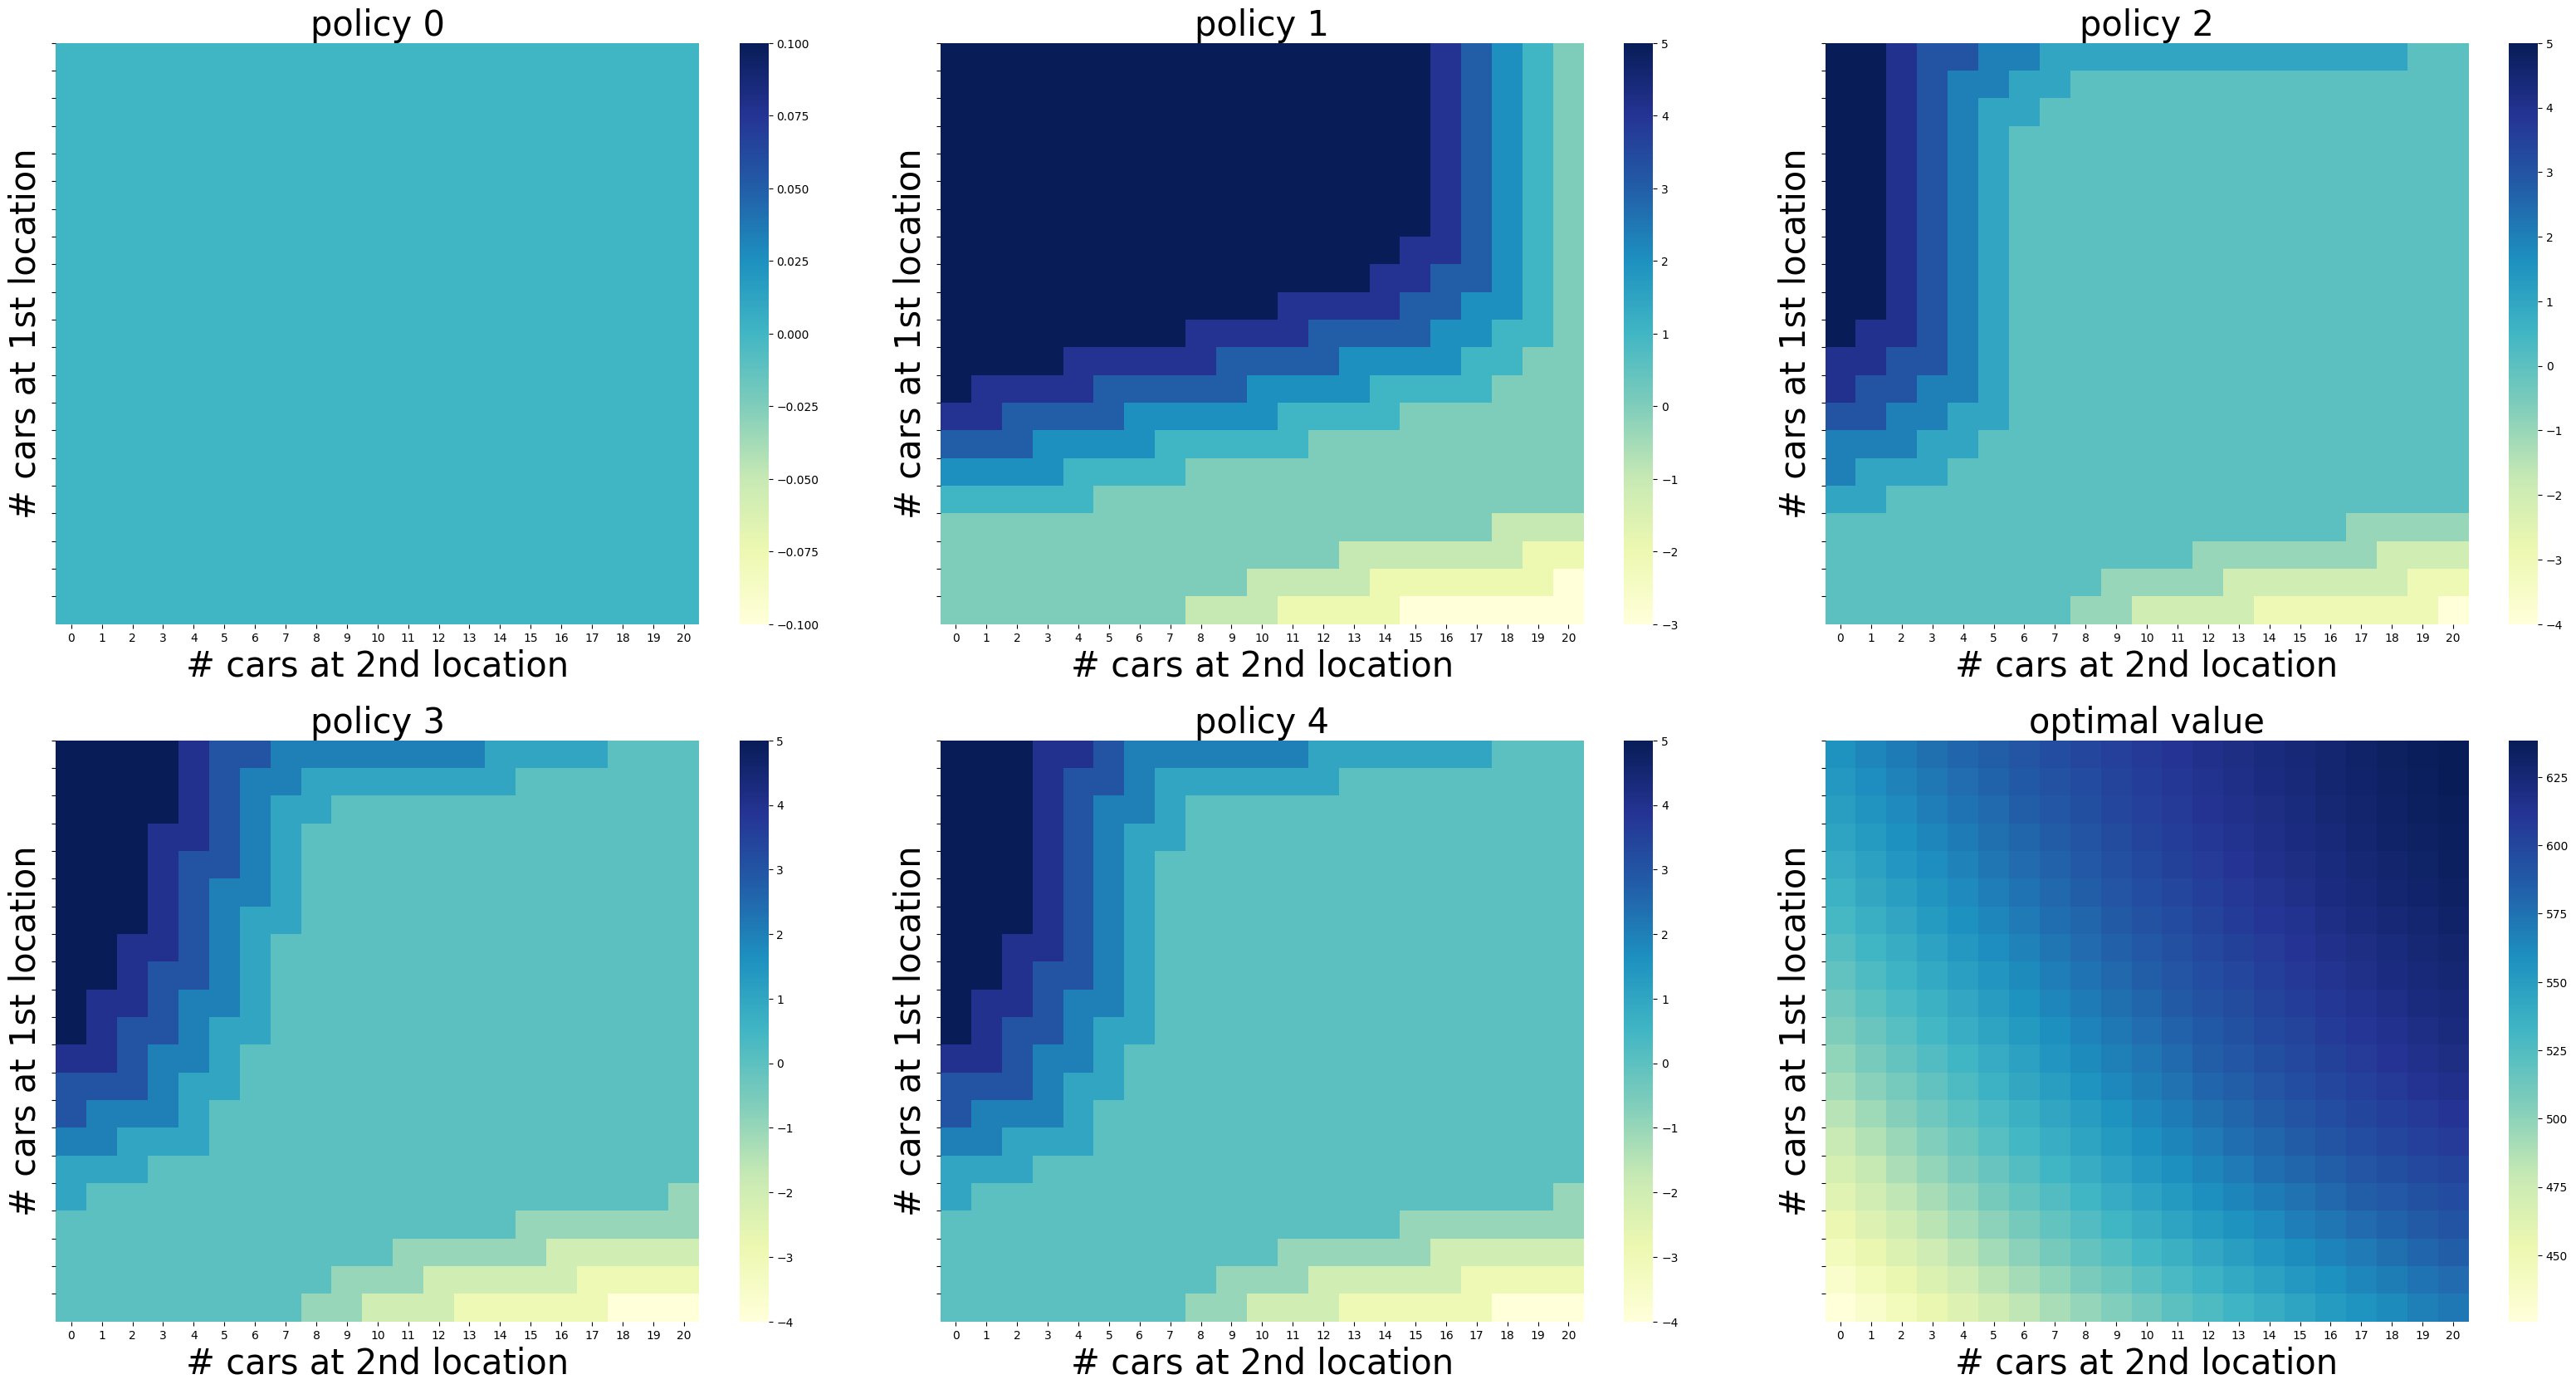

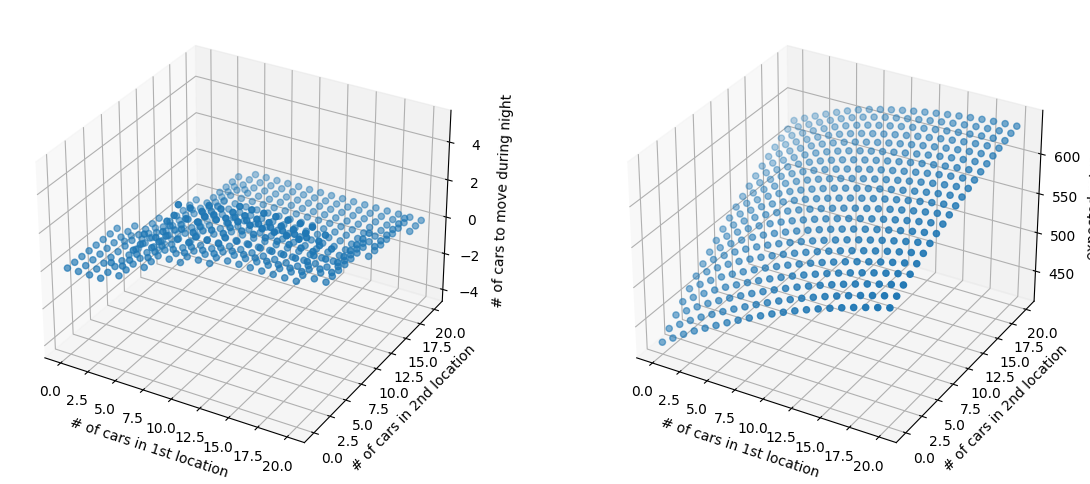

In [35]:
policy_iteration()

### ordinary version  
  
- easy to understand

In [ ]:
import matplotlib.pyplot as plt
import numpy  as np
import seaborn as sns
from scipy.stats import poisson

%matplotlib inline

MAX_CAR_LIMIT = 20      # maximum # of cars in each location
MAX_MOVE_LIMIT = 5      # maximum # of cars to move during night
EXP_REQ_1 = 3       # expectation of rental requests in 1st location
EXP_REQ_2 = 4       # expectation of rental requests in 2nd location
EXP_RET_1 = 3       # expectation of # of cars returned in 1st location
EXP_RET_2 = 2       # expectation of # of cars returned in 2nd location

stateValue = np.zeros((MAX_CAR_LIMIT + 1, MAX_CAR_LIMIT + 1))  # state value
policy = np.zeros(stateValue.shape, dtype = int)               # store action taken of each state             

DISCOUNT = 0.9

RENTAL_CREDIT = 10      # RENTAL_CREDIT earned by a car
MOVE_CAR_COST = 2       # cost of moving a car

actions = np.arange(-MAX_MOVE_LIMIT, MAX_MOVE_LIMIT + 1)   # action space is whether to move a car
                                                        # since it can be controled by an agent
                                                        # neither `rental` nor `return` cannot be controled by an agent

POISSON_UPPER_BOUND = 12        # If n is greater than 11, then the probability of getting n is truncated to 0.
poisson_cache = dict()  # store probability to ensure consistency

def poisson_prob(n, expectation):
    global poisson_cache
    # hashlize
    key = f"n{n}e{expectation}"
    if key not in poisson_cache:
        poisson_cache[key] = poisson.pmf(n, expectation)    # calculate the probability from Poisson(expectation) when an event happens n times
    return poisson_cache[key]

def get_return(state, action, stateValue, constantReturnedCars: bool = True) -> int:
    """
    param: state [# of cars in 1st location, # of cars in 2nd location]
    param: action: whether to move a car or not, 
                positive if `1st location -> 2nd location`
                negative if `1st location <- 2nd location`
    param: stateValue: a matrix with size `(MAX_CAR_LIMIT, MAX_CAR_LIMIT)` storing stateValue

    return: return
    """
    returns = 0.0   # initialize total return
    returns -= MOVE_CAR_COST * abs(action)  # cost of moving cars

    # numver of cars after moving
    num_of_cars_1 = min(state[0] - action, MAX_CAR_LIMIT)
    num_of_cars_2 = min(state[1] + action, MAX_CAR_LIMIT)

    # go through all possible rental request
    # V(s) = \sum_{s', r}p(s', r|s, \pi(s))[r + \gamma\times V(s')]
    # since if numb of requests > num of available cars, the bussiness will miss without any other results
    # we assume the greatest request num is num of available cars
    for request_1_loc in range(POISSON_UPPER_BOUND + 1):
        for request_2_loc in range(POISSON_UPPER_BOUND + 1):
            prob_request = poisson_prob(request_1_loc, EXP_REQ_1) * \
            poisson_prob(request_2_loc, EXP_REQ_2)

            valid_rental_1 = min(num_of_cars_1, request_1_loc)
            valid_rental_2 = min(num_of_cars_2, request_2_loc)
            
            # get RENTAL_CREDITs for renting
            reward = (valid_rental_1 + valid_rental_2) * RENTAL_CREDIT
            res_cars_1 = num_of_cars_1 - valid_rental_1
            res_cars_2 = num_of_cars_2 - valid_rental_2

            # returned cars

            """constant returned"""
            if constantReturnedCars:
                res_cars_1 = min(res_cars_1 + EXP_RET_1, MAX_CAR_LIMIT)
                res_cars_2 = min(res_cars_2 + EXP_RET_2, MAX_CAR_LIMIT)
                returns += prob_request * (reward + DISCOUNT * stateValue[res_cars_1, res_cars_2])

            else:
                for returned_cars_1_loc in range(POISSON_UPPER_BOUND):
                    for returned_cars_2_loc in range(POISSON_UPPER_BOUND):
                        prob_return = poisson_prob(returned_cars_1_loc, EXP_RET_1) * \
                            poisson_prob(returned_cars_2_loc, EXP_RET_2)
                        
                        res_cars_1 = min(res_cars_1 + returned_cars_1_loc, MAX_CAR_LIMIT)
                        res_cars_2 = min(res_cars_2 + returned_cars_2_loc, MAX_CAR_LIMIT)
                        prob = prob_request * prob_return
                        # q(s', s, a) = r(s, a) + \gamma\times V(s')
                        # V(s) = \sum_{s', r}p(s', r|s, \pi(s))[r + \gamma\times V(s')]
                        returns += prob * (reward + DISCOUNT * stateValue[res_cars_1, res_cars_2])
    
    return returns



def addFigure(data, labels, index):
    fig1 = plt.figure(index)
    ax = fig1.add_subplot(111, projection = '3d')
    AxisZ = []
    AxisXPrint = []
    AxisYPrint = []
    for i in range(MAX_CAR_LIMIT + 1):
        for j in range(MAX_CAR_LIMIT + 1):
            AxisXPrint.append(i)
            AxisYPrint.append(j)
            AxisZ.append(data[i, j])
    
    ax.scatter(AxisXPrint, AxisYPrint, AxisZ)
    ax.set_xlabel(labels[0])
    ax.set_ylabel(labels[1])
    ax.set_zlabel(labels[2])



def policy_iteration():
    iterations = 0
    _, axes = plt.subplots(2, 3, figsize = (40, 20))
    plt.subplots_adjust(wspace = 0.1, hspace = 0.2)
    axes = axes.flatten()

    while True:
        fig = sns.heatmap(np.flipud(policy), cmap = 'YlGnBu', ax = axes[iterations])
        fig.set_ylabel('# cars at 1st location', fontsize = 30)
        fig.set_yticks(list(reversed(range(MAX_CAR_LIMIT + 1))))
        fig.set_xlabel('# cars at 2nd location', fontsize = 30)
        fig.set_title('policy {}'.format(iterations), fontsize = 30)

        # policy evaluation (in-place)
        while True:
            old_value = stateValue.copy()
            for i in range(MAX_CAR_LIMIT + 1):
                for j in range(MAX_CAR_LIMIT + 1):
                    update_stateValue = get_return([i, j], policy[i, j], stateValue)
                    stateValue[i, j] = update_stateValue
            
            max_value_change = abs(old_value - stateValue).max()
            print('max value change {}'.format(max_value_change))
            if max_value_change < 1e-4:
                break
        
        # policy improvement
        policy_stable = True
        for i in range(MAX_CAR_LIMIT + 1):
            for j in range(MAX_CAR_LIMIT + 1):
                old_action = policy[i, j]
                action_returns = []
                for action in actions:
                    # get valid action from action space under specific state
                    if (0 <= action <= i) or (-j <= action <= 0):
                        action_returns.append(get_return([i, j], action, stateValue))
                    else:
                        action_returns.append(-np.inf)
                
                update_action = actions[np.argmax(action_returns)]
                policy[i, j] = update_action
                if policy_stable and old_action != update_action:
                    policy_stable = False

        print('policy state {}'.format(policy_stable))

        if policy_stable:
            fig = sns.heatmap(np.flipud(stateValue), cmap = 'YlGnBu', ax = axes[-1])
            fig.set_ylabel('# cars at 1st location', fontsize = 30)
            fig.set_yticks(list(reversed(range(MAX_CAR_LIMIT + 1))))
            fig.set_xlabel('# cars at 2nd location', fontsize = 30)
            fig.set_title('optimal value', fontsize = 30)
            break

        iterations += 1

    plt.savefig('./policy_iteration.png')
    plt.show()
    plt.close()

    def addSubplot(ax, data, label):
        AxisZ = []
        AxisXPrint = []
        AxisYPrint = []
        for i in range(MAX_CAR_LIMIT + 1):
            for j in range(MAX_CAR_LIMIT + 1):
                AxisXPrint.append(i)
                AxisYPrint.append(j)
                AxisZ.append(data[i, j])

        ax.scatter(AxisXPrint, AxisYPrint, AxisZ)
        ax.set_xlabel(label[0])
        ax.set_ylabel(label[1])
        ax.set_zlabel(label[2])

    def gen3d(policy, stateValues):
        fig = plt.figure(figsize=(14, 6))  
        ax1 = fig.add_subplot(121, projection='3d')  
        ax2 = fig.add_subplot(122, projection='3d')  

        addSubplot(ax1, policy, ['# of cars in 1st location', '# of cars in 2nd location', '# of cars to move during night'])
        addSubplot(ax2, stateValues, ['# of cars in 1st location', '# of cars in 2nd location', 'expected returns'])

        # plt.savefig('./exp-3d.png')  
        plt.show()  
        
    
    gen3d(policy, stateValues)



max value change 198.59982085535668
max value change 136.76046545624902
max value change 92.90038843959212
max value change 68.26883468173355
max value change 52.284637989111445
max value change 39.390543703872254
max value change 30.117454422463595
max value change 26.446189090010705
max value change 23.103448710665532
max value change 20.10939663420322
max value change 17.455423144925646
max value change 15.11953763898839
max value change 13.07406239991144
max value change 11.289668470045285
max value change 9.73754000639127
max value change 8.390512785230158
max value change 7.223621487574746
max value change 6.214299922110797
max value change 5.342380459125877
max value change 4.589982516290149
max value change 3.9413449771393516
max value change 3.3826353496415322
max value change 2.9017546905089944
max value change 2.4881488912150758
max value change 2.132631865796725
max value change 1.8272231967825405
max value change 1.5650010605126
max value change 1.3399702627112333
max valu

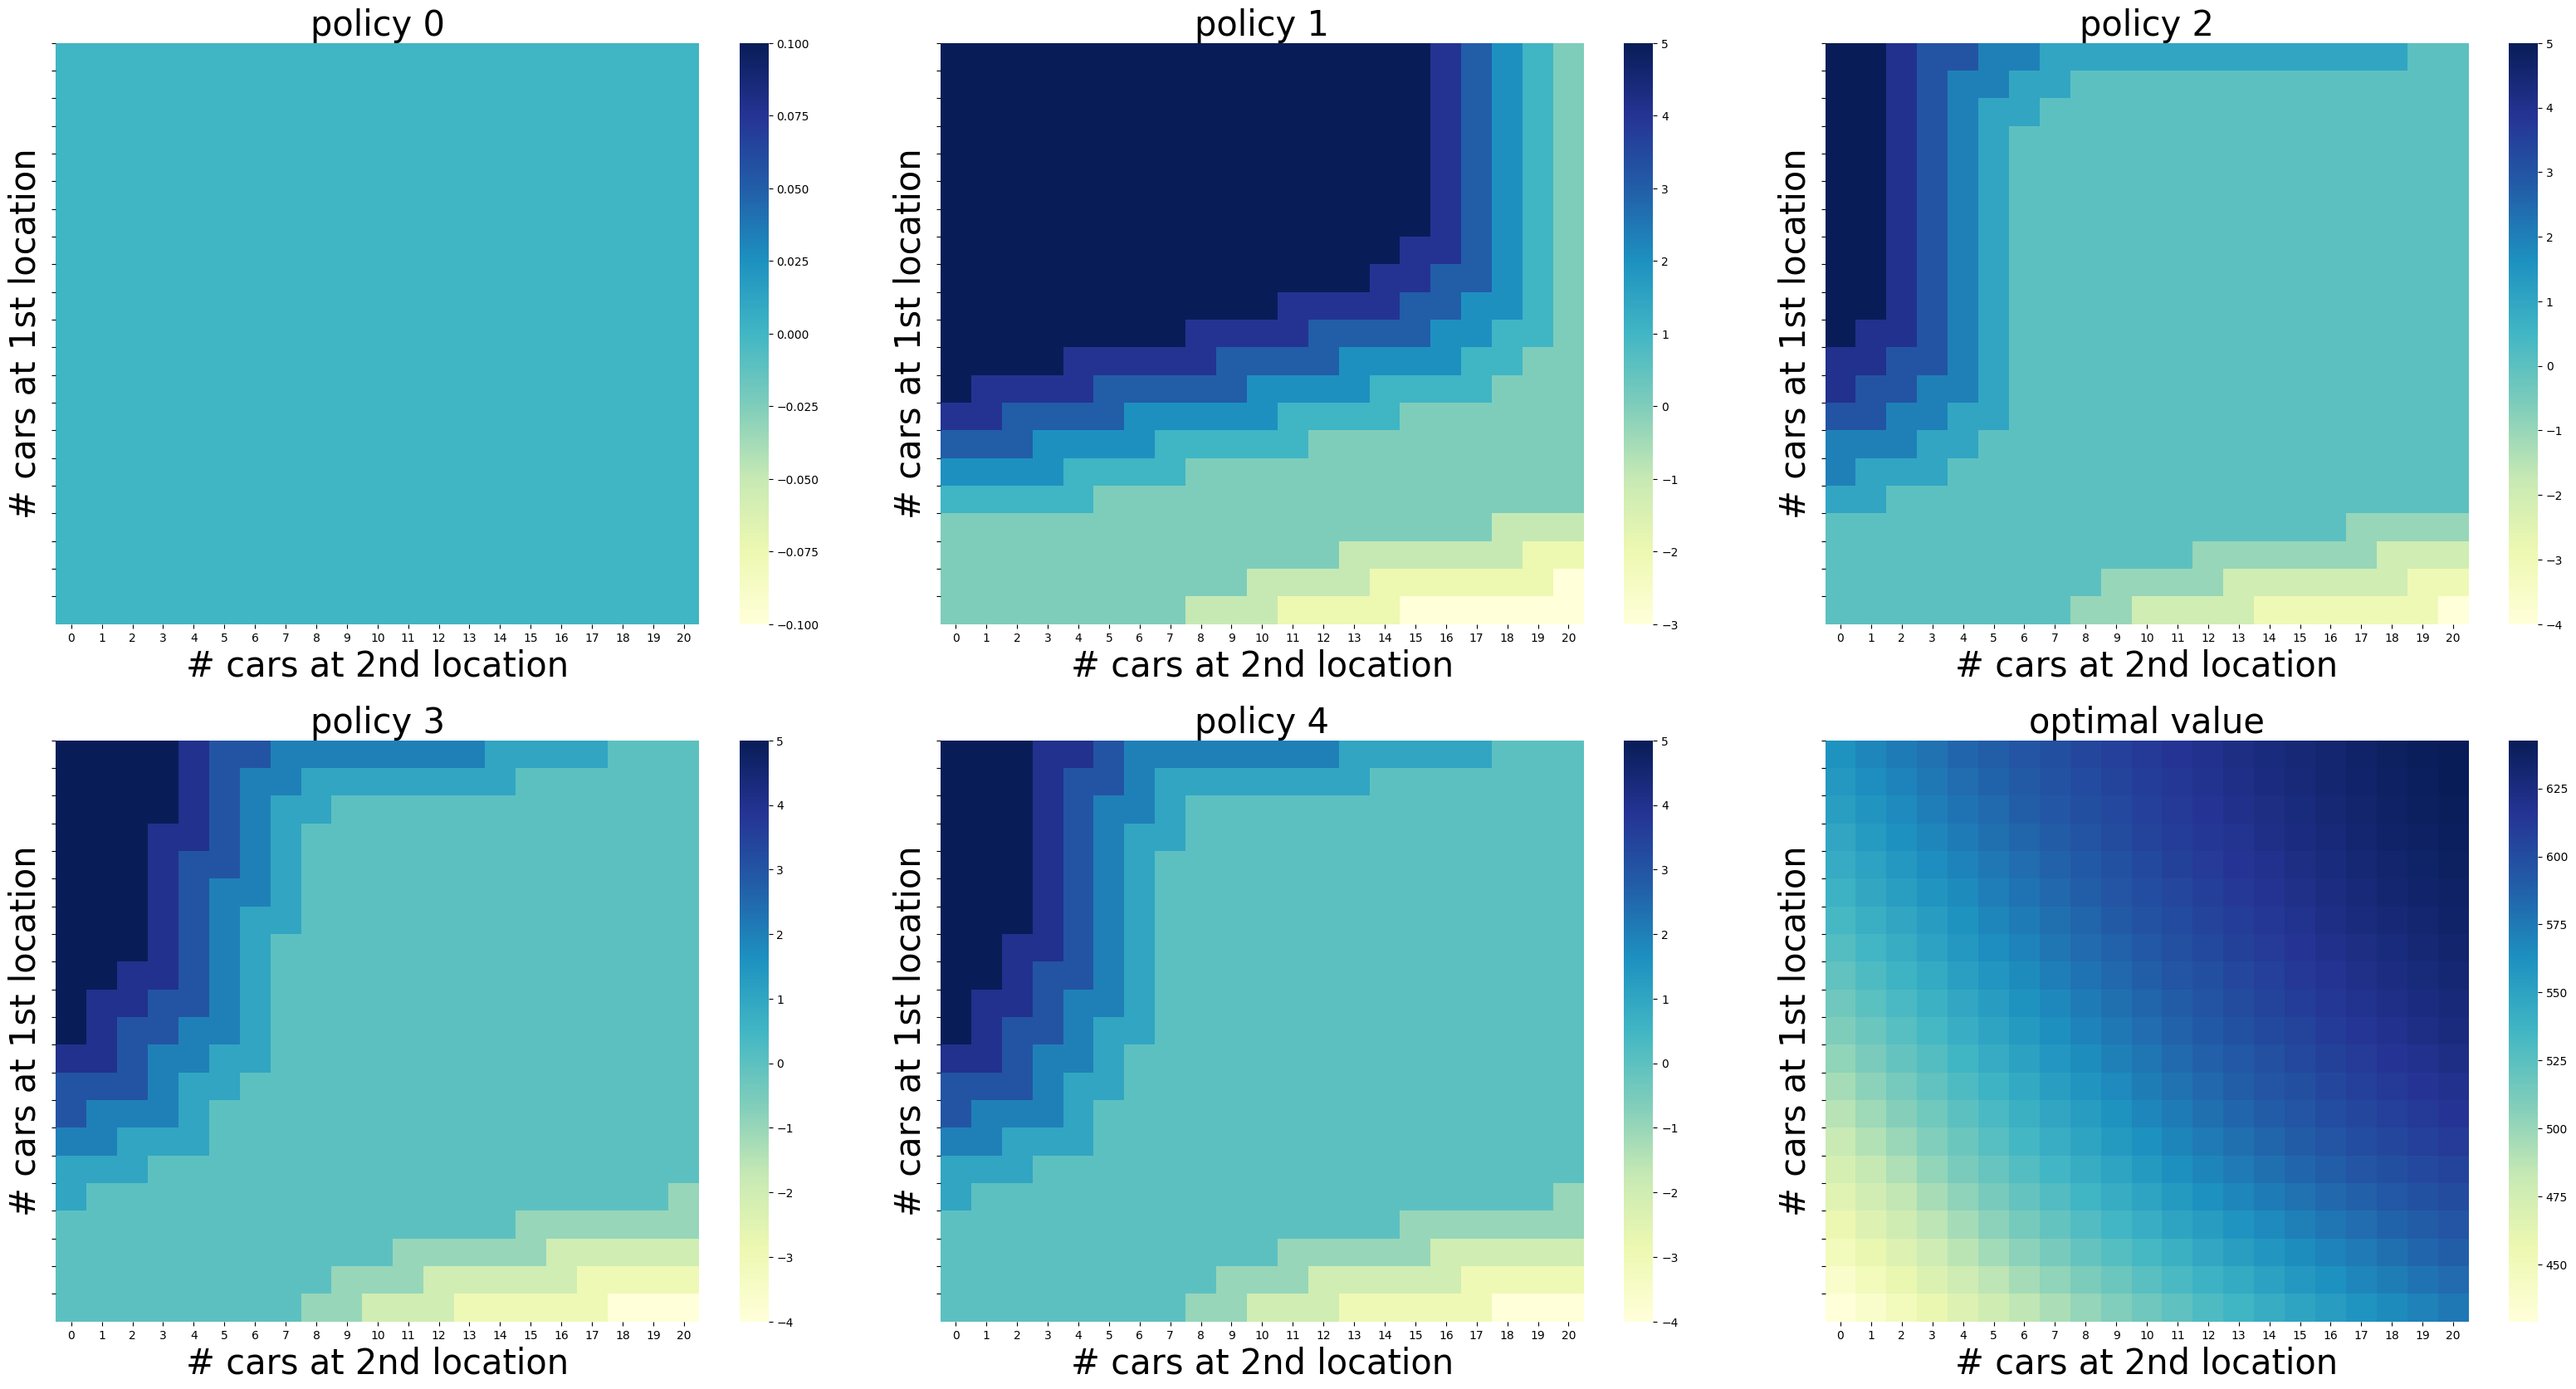

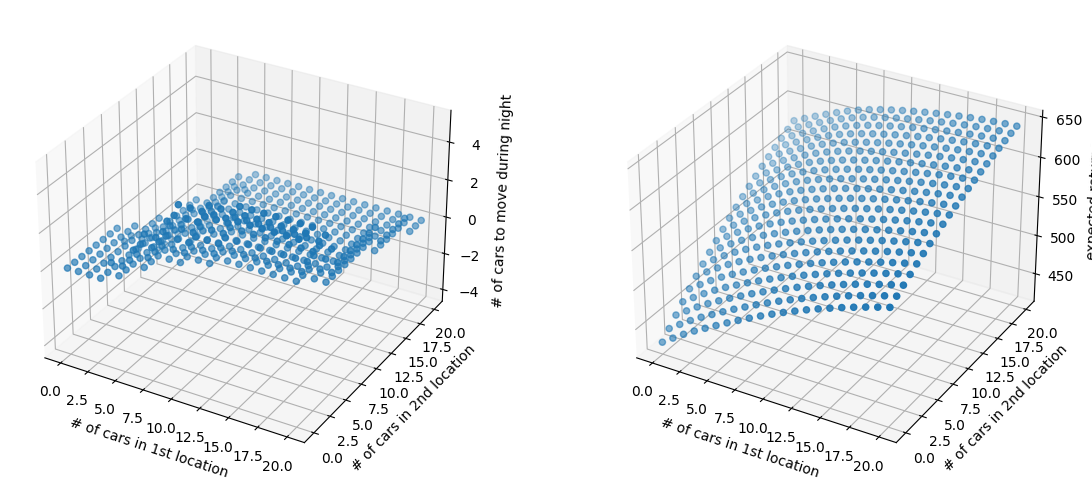

In [33]:
policy_iteration()